# Model Training

## i. Importing packages

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.transform import resize
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
import os

print("Import Successful")

Import Successful


## ii. Loading dataset

In [59]:
img_size = 64
target_dims = (img_size, img_size, 3)
n_size = 29
train_size = 87000

# using os.path here since our os are mismatched
nb_path = os.getcwd()
train_dir = os.path.join(nb_path, 'asl_alphabet_train')

def load_data(path):
    x = np.empty((train_size, img_size, img_size, 3), dtype = np.float32)
    Y = np.empty((train_size, ), dtype = int)
    label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'space': 27, 'nothing': 28}
    count = 0
    for folder in os.listdir(path):
        if not folder.startswith('.'):
            if folder in label_map:
                label = label_map[folder]
            else:
                label = 29
            for img_name in os.listdir(os.path.join(path, folder)):
                img = cv2.imread(os.path.join(path, folder, img_name))
                if img is not None:
                    scale_factor = np.random.uniform(0.8, 1.2)
                    zoomed_image = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)
                    alpha = np.random.uniform(0.8, 1.2)
                    beta = np.random.uniform(-20, 20)
                    brightness_contrast_image = cv2.convertScaleAbs(zoomed_image, alpha=alpha, beta=beta)
                    img = skimage.transform.resize(brightness_contrast_image, (img_size, img_size, 3))
                    img_arr = np.asarray(img).reshape((-1, img_size, img_size, 3))
                    
                    x[count] = img_arr
                    Y[count] = label
                    count += 1
    return x, Y

# Load in Data from directory
x_train, Y_train = load_data(train_dir)

### Checking the data:

In [60]:
print(x_train.shape)
print(Y_train.shape)
print(x_train[12].shape)

(87000, 64, 64, 3)
(87000,)
(64, 64, 3)


### View an image:

<function matplotlib.pyplot.show(close=None, block=None)>

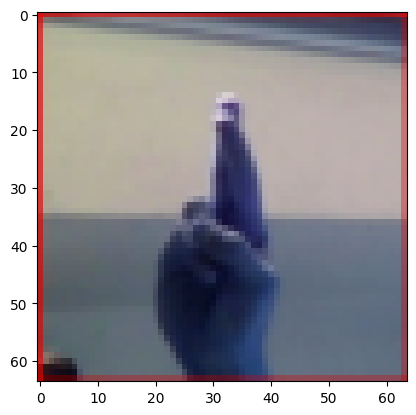

In [70]:
plt.imshow(x_train[59999])
plt.show


# 1. Data Processing

## Train/Test Split


In [71]:
from sklearn.model_selection import train_test_split

# making copies of original data
x_data = x_train
Y_data = Y_train

# spliting the data and stratfying on Y
xtrain, xtest, ytrain, ytest = train_test_split(x_data, Y_data, test_size=0.25, random_state=42, stratify=Y_data)

### Categorical data

In [72]:
# Create Matrix
from tensorflow.keras.utils import to_categorical
ycat_train = to_categorical(ytrain, 29)
ycat_test = to_categorical(ytest, 29)

### Sanity Check

In [73]:
# The dimensions should be correct
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest)
print(ycat_train.shape)

(65250, 64, 64, 3)
(65250,)
(21750, 64, 64, 3)
[ 6  7 22 ...  7 28 13]
(65250, 29)


# 2. Build a Sequential Model

In [74]:
# 3 layer model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation="relu", input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),  # Add dropout layer with rate 0.25
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Add L2 regularization
    tf.keras.layers.Dense(29, activation="softmax")
])


## Sanity Check Part 2

In [75]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 128)       

## Model Compile

In [76]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

# 3. Model Fitting

## Import early stops

In [77]:
from tensorflow.keras.callbacks import EarlyStopping
stop_the_train = EarlyStopping(monitor = 'val_loss', patience = 2)

## Input data into model


In [78]:
# The part where the computer does all the work :)

model.fit(
    xtrain, ycat_train,
    epochs=20,
    batch_size=64,
    verbose=2,
    validation_data=(xtest, ycat_test),
    callbacks=[stop_the_train]
)

Epoch 1/20
1020/1020 - 128s - loss: 1.5718 - accuracy: 0.6615 - val_loss: 0.9076 - val_accuracy: 0.8581 - 128s/epoch - 126ms/step
Epoch 2/20
1020/1020 - 123s - loss: 0.7723 - accuracy: 0.8881 - val_loss: 0.6194 - val_accuracy: 0.9288 - 123s/epoch - 120ms/step
Epoch 3/20
1020/1020 - 120s - loss: 0.6535 - accuracy: 0.9186 - val_loss: 0.5840 - val_accuracy: 0.9375 - 120s/epoch - 118ms/step
Epoch 4/20
1020/1020 - 114s - loss: 0.5794 - accuracy: 0.9364 - val_loss: 0.4983 - val_accuracy: 0.9564 - 114s/epoch - 112ms/step
Epoch 5/20
1020/1020 - 113s - loss: 0.5348 - accuracy: 0.9461 - val_loss: 0.4476 - val_accuracy: 0.9699 - 113s/epoch - 110ms/step
Epoch 6/20
1020/1020 - 119s - loss: 0.5096 - accuracy: 0.9517 - val_loss: 0.4066 - val_accuracy: 0.9769 - 119s/epoch - 116ms/step
Epoch 7/20
1020/1020 - 110s - loss: 0.4838 - accuracy: 0.9571 - val_loss: 0.4458 - val_accuracy: 0.9770 - 110s/epoch - 108ms/step
Epoch 8/20
1020/1020 - 109s - loss: 0.4623 - accuracy: 0.9602 - val_loss: 0.4334 - val_acc

## Metrics



In [79]:
# Creating a table for the loss/acc
pd.DataFrame(model.history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.571772,0.661533,0.907611,0.858115
1,0.772293,0.888138,0.619422,0.928828
2,0.653513,0.918559,0.583999,0.937517
3,0.579387,0.936429,0.498295,0.956368
4,0.534765,0.946069,0.447572,0.969885
5,0.509580,0.951693,0.406641,0.976874
6,0.483776,0.957134,0.445802,0.977012
7,0.462293,0.960153,0.433358,0.979632


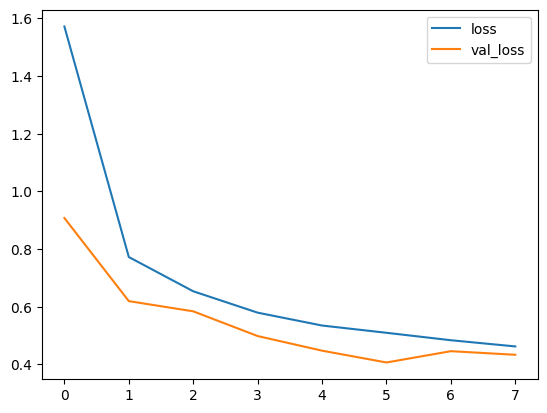

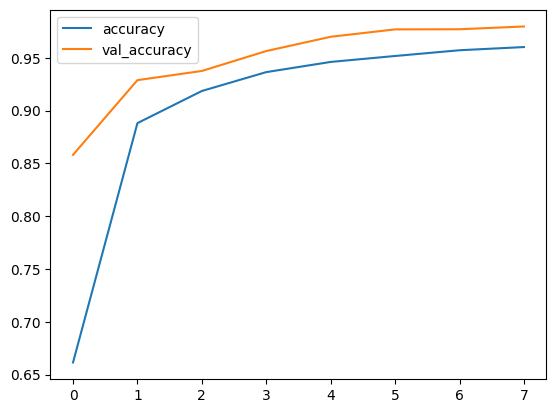

In [80]:
# visualization of loss and accuracy
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot()
plt.show()

# 4. Model Validation

In [81]:
# Making Predictions
predict = np.argmax(model.predict(xtest), axis=-1)

680/680 [==============================] - 8s 12ms/step


## Testing against the test response

In [82]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       750
           1       0.99      0.96      0.97       750
           2       0.98      1.00      0.99       750
           3       0.97      1.00      0.98       750
           4       0.94      0.99      0.96       750
           5       0.99      1.00      1.00       750
           6       1.00      0.98      0.99       750
           7       0.97      1.00      0.98       750
           8       0.98      0.96      0.97       750
           9       1.00      1.00      1.00       750
          10       1.00      0.96      0.98       750
          11       0.97      0.99      0.98       750
          12       0.99      0.96      0.97       750
          13       0.97      0.99      0.98       750
          14       0.99      0.96      0.98       750
          15       0.98      1.00      0.99       750
          16       0.97      0.99      0.98       750
          17       0.97    

## Confusion matrix

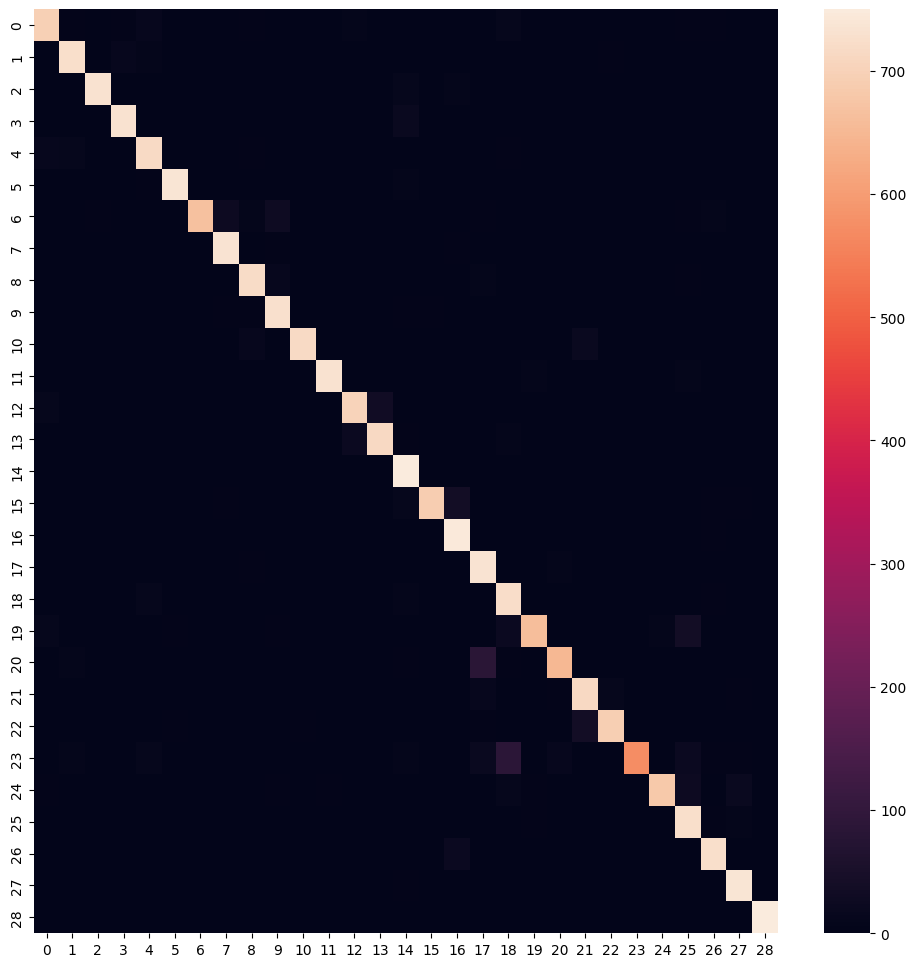

In [57]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(ytest, predict))
plt.show()

# iii. Save Model

In [83]:
from keras.models import load_model
model.save("Model_asl_dense_nospin.model", save_format = "h5")